In [2]:
!pip install tensorflow
!pip install nltk

In [3]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Bi-LSTM and GloVe Embedding**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      31,805,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,805,000 (121.33 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 31,805,000 (121.33 MB)

Epoch 1/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.4979 - loss: 0.6946 - val_accuracy: 0.5004 - val_loss: 0.6934
Epoch 2/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.4979 - val_loss: 0.6934
Epoch 3/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - accuracy: 0.5106 - loss: 0.6927 - val_accuracy: 0.4984 - val_loss: 0.6944
Epoch 4/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.5165 - loss: 0.6915 - val_accuracy: 0.4982 - val_loss: 0.6947
Epoch 5/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.5332 - loss: 0.6881 - val_accuracy: 0.4964 - val_loss: 0.6998
Epoch 6/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - accuracy: 0.5499 - loss: 0.6802 - val_accuracy: 0.4931 - val_loss: 0.7089
Epoch 7/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.5766 - loss: 0.6658 - val_accuracy: 0.4948 - val_loss: 0.7231
Epoch 8/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.5997 -

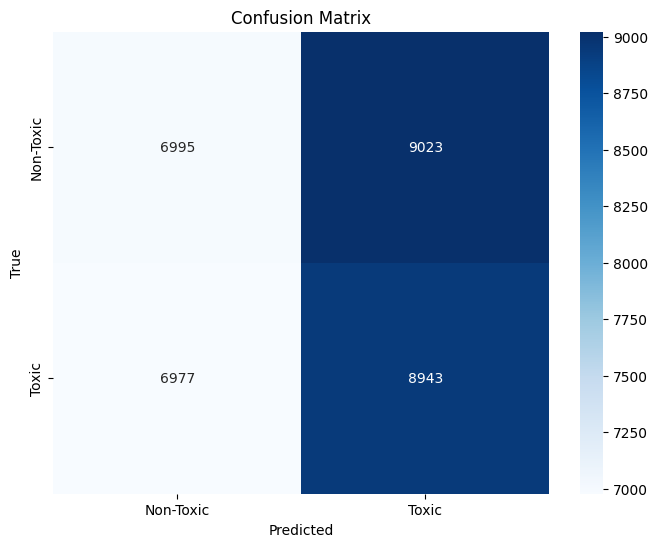

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Comments.csv"
glove_path = "/content/drive/My Drive/glove.6B.100d.txt"

# Step 1: Load the dataset
df = pd.read_csv(data_path)

# Step 2: Preprocessing
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = text.lower()  # Lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stop words
    return text

df['comment'] = df['comment'].apply(preprocess_text)

# Step 3: Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment'])
word_index = tokenizer.word_index

max_length = 100
sequences = tokenizer.texts_to_sequences(df['comment'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Step 4: Prepare Labels and Split Data
labels = df['toxicity']  # Assuming 1 = Toxic, 0 = Non-Toxic (adjust as needed)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Step 5: Load GloVe Embeddings
embedding_dim = 100
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Step 6: Build Bi-LSTM Model
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(100)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Step 7: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Step 8: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 9: Predict and Plot Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **BERT**

Loading dataset...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reducing dataset size for faster execution...
Preparing data...
Loading DistilBERT tokenizer...
Tokenizer loaded successfully.
Splitting dataset into train, test, and dev sets...
Datasets prepared successfully.
Loading DistilBERT model...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model loaded and moved to device.
Defining optimizer and loss function...
Optimizer and loss function defined.
Starting training process...
Epoch 1...
Epoch 1 completed. Loss: 0.6955391903718312
Saving trained model...
Model saved successfully.
Evaluating the model...
Evaluating on Test Set...
Calculating metrics for Test Set...


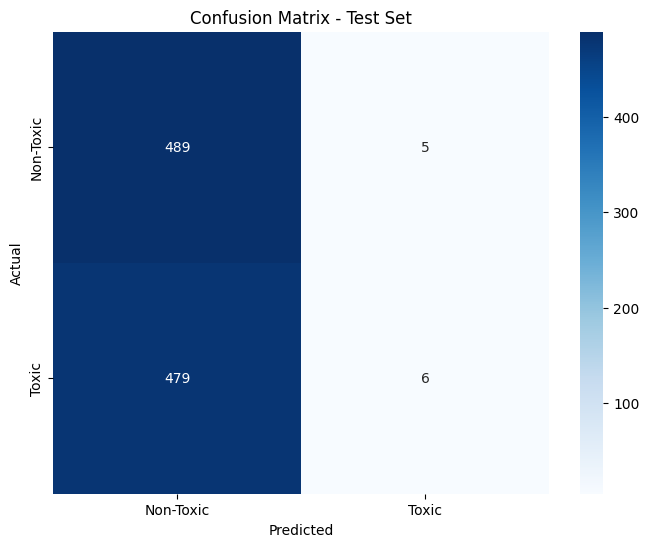

Metrics for Test Set:
        Metric     Value
0    Precision  0.545455
1       Recall  0.012371
2    F-Measure  0.024194
3     Accuracy  0.505618
4  Sensitivity  0.012371
5  Specificity  0.989879
Evaluating on Dev Set...
Calculating metrics for Dev Set...


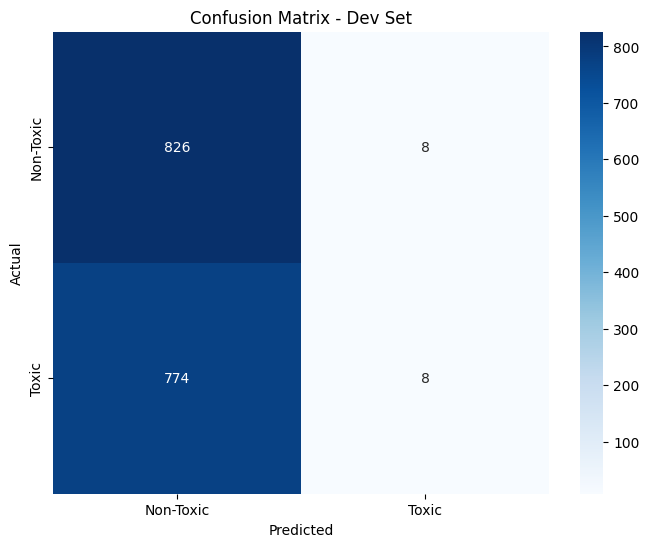

Metrics for Dev Set:
        Metric     Value
0    Precision  0.500000
1       Recall  0.010230
2    F-Measure  0.020050
3     Accuracy  0.516089
4  Sensitivity  0.010230
5  Specificity  0.990408
Evaluation completed.


In [13]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
print("Loading dataset...")

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Comments.csv"
glove_path = "/content/drive/My Drive/glove.6B.100d.txt"

# Step 2: Reduce dataset for faster execution
print("Reducing dataset size for faster execution...")
train_data = df[df['split'] == 'train'].sample(frac=0.1, random_state=42)  # Use 10% of training data
test_data = df[df['split'] == 'test'].sample(frac=0.3, random_state=42)    # Use 30% of test data
dev_data = df[df['split'] == 'dev'].sample(frac=0.5, random_state=42)      # Use 50% of dev data

# Step 3: Prepare data
print("Preparing data...")
class ToxicityDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_length):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, index):
        comment = self.comments[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer
print("Loading DistilBERT tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("Tokenizer loaded successfully.")

# Prepare datasets
print("Splitting dataset into train, test, and dev sets...")
max_length = 64  # Reduced sequence length for faster execution
train_dataset = ToxicityDataset(train_data['comment'].tolist(), train_data['toxicity'].tolist(), tokenizer, max_length)
test_dataset = ToxicityDataset(test_data['comment'].tolist(), test_data['toxicity'].tolist(), tokenizer, max_length)
dev_dataset = ToxicityDataset(dev_data['comment'].tolist(), dev_data['toxicity'].tolist(), tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4)  # Larger batch size and parallel loading
dev_loader = DataLoader(dev_dataset, batch_size=32)
print("Datasets prepared successfully.")

# Step 4: Load DistilBERT model
print("Loading DistilBERT model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Freeze DistilBERT base layers for faster training (optional)
for param in model.distilbert.parameters():
    param.requires_grad = False

model = model.to(device)
print("DistilBERT model loaded and moved to device.")

# Step 5: Define optimizer and loss function
print("Defining optimizer and loss function...")
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
print("Optimizer and loss function defined.")

# Step 6: Train the model
print("Starting training process...")
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

for epoch in range(1):  # Reduced to 1 epoch
    print(f"Epoch {epoch + 1}...")
    loss = train_model(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1} completed. Loss: {loss}")

# Save model after training
print("Saving trained model...")
model.save_pretrained("distilbert_toxicity_model")
tokenizer.save_pretrained("distilbert_toxicity_model")
print("Model saved successfully.")

# Step 7: Evaluate the model
print("Evaluating the model...")
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def calculate_metrics(y_true, y_pred, dataset_name):
    print(f"Calculating metrics for {dataset_name}...")
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Sensitivity and Specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

    # Display Metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F-Measure', 'Accuracy', 'Sensitivity', 'Specificity'],
        'Value': [precision, recall, f_measure, accuracy, sensitivity, specificity]
    })
    print(f"Metrics for {dataset_name}:")
    print(metrics_df)
    return metrics_df

# Test Set
print("Evaluating on Test Set...")
y_test_pred, y_test_true = evaluate_model(model, test_loader, device)
test_metrics = calculate_metrics(y_test_true, y_test_pred, "Test Set")

# Dev Set
print("Evaluating on Dev Set...")
y_dev_pred, y_dev_true = evaluate_model(model, dev_loader, device)
dev_metrics = calculate_metrics(y_dev_true, y_dev_pred, "Dev Set")
print("Evaluation completed.")


# **# Feature Fusion with BERT**

Step 1: Loading dataset...
Mounted at /content/drive
Step 2: Extracting features from comments...
Features extracted successfully.
Step 3: Tokenizing text with DistilBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Step 3: Preparing datasets...
Datasets prepared successfully.
Step 4: Loading DistilBERT model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model loaded and moved to device.
Step 5: Extracting features from BERT...
BERT features extracted successfully.
Step 5: Extracting features from BERT...
BERT features extracted successfully.
Step 6: Combining BERT features with other features...
Features combined successfully.
Step 7: Training classification models...
Evaluating SVM...


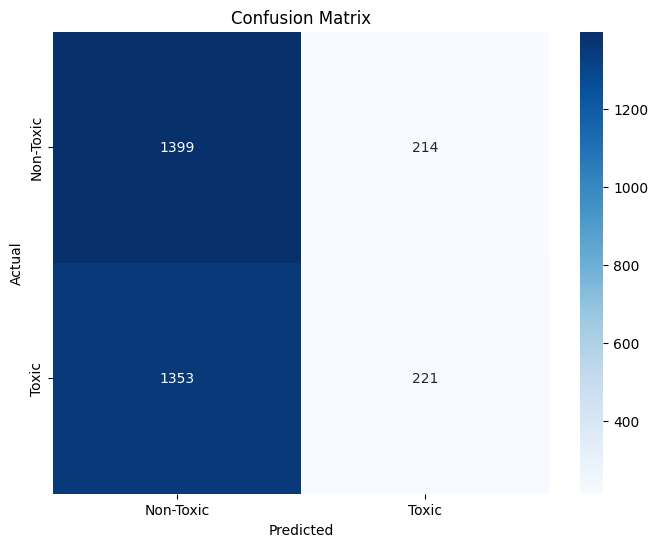

      Metric     Value
0  Precision  0.508046
1     Recall  0.140407
2  F-Measure  0.220010
3   Accuracy  0.508315
Evaluating Logistic Regression...


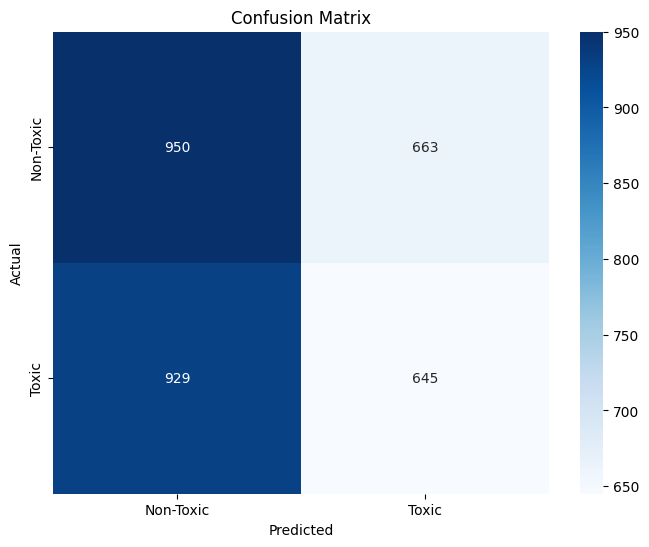

      Metric     Value
0  Precision  0.493119
1     Recall  0.409784
2  F-Measure  0.447606
3   Accuracy  0.500471
Evaluating Random Forest...


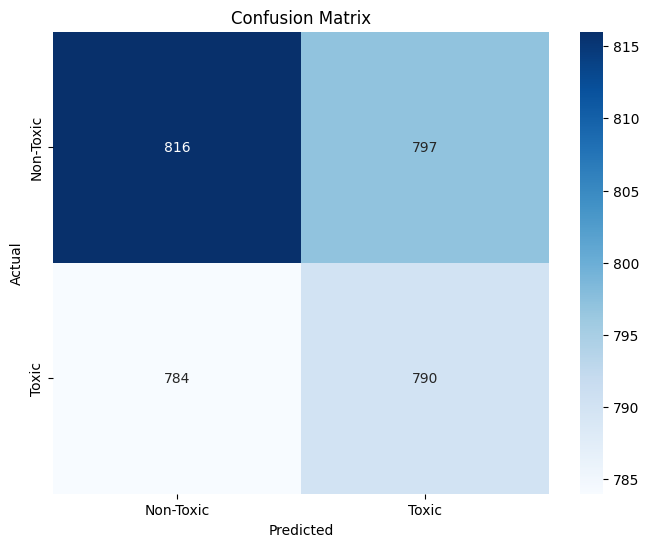

      Metric     Value
0  Precision  0.497795
1     Recall  0.501906
2  F-Measure  0.499842
3   Accuracy  0.503922
Evaluating Decision Tree...


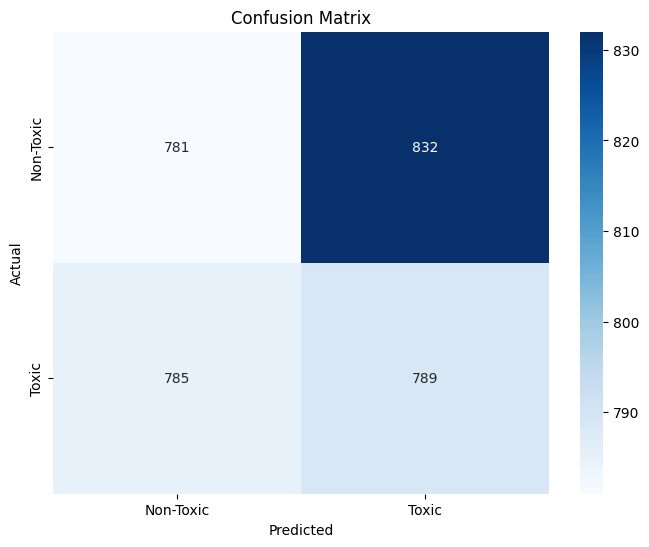

      Metric     Value
0  Precision  0.486737
1     Recall  0.501271
2  F-Measure  0.493897
3   Accuracy  0.492626
Evaluating KNN...


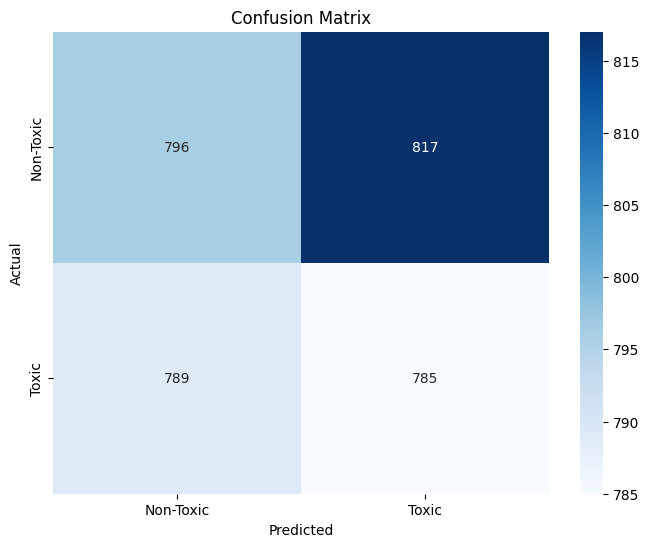

      Metric     Value
0  Precision  0.490012
1     Recall  0.498729
2  F-Measure  0.494332
3   Accuracy  0.496078


In [2]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
print("Step 1: Loading dataset...")

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Comments.csv"
df = pd.read_csv(data_path)

# Step 2: Data preprocessing (include sentiment, hashtags, and other features)
def extract_features(df):
    print("Step 2: Extracting features from comments...")
    df['sentiment'] = df['comment'].apply(lambda x: 1 if 'positive' in x else 0)  # Example feature
    df['hashtags'] = df['comment'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))  # Example feature
    df['syntax_feature'] = df['comment'].apply(lambda x: len([word for word in x.split() if word in ["is", "am", "are"]]))  # Example syntactic feature
    print("Features extracted successfully.")
    return df

df = extract_features(df)

# Step 3: Tokenize text with DistilBERT
print("Step 3: Tokenizing text with DistilBERT...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 64  # Keeping max_length low for faster processing

class ToxicityDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_length):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, index):
        comment = self.comments[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Step 3: Prepare datasets
print("Step 3: Preparing datasets...")

# Reduce dataset to a smaller size (only 10% of training data)
train_data = df[df['split'] == 'train'].sample(frac=0.1, random_state=42)  # 10% of training data
test_data = df[df['split'] == 'test'].sample(frac=0.1, random_state=42)    # 10% of test data
dev_data = df[df['split'] == 'dev'].sample(frac=0.1, random_state=42)      # 10% of dev data

train_dataset = ToxicityDataset(train_data['comment'].tolist(), train_data['toxicity'].tolist(), tokenizer, max_length)
test_dataset = ToxicityDataset(test_data['comment'].tolist(), test_data['toxicity'].tolist(), tokenizer, max_length)
dev_dataset = ToxicityDataset(dev_data['comment'].tolist(), dev_data['toxicity'].tolist(), tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)
dev_loader = DataLoader(dev_dataset, batch_size=32, num_workers=2)

print("Datasets prepared successfully.")

# Step 4: Load DistilBERT model
print("Step 4: Loading DistilBERT model...")
device = torch.device("cpu")  # Use CPU instead of GPU for faster execution

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

print("DistilBERT model loaded and moved to device.")

# Step 5: Extract features from BERT
def extract_bert_features(model, data_loader, device):
    print("Step 5: Extracting features from BERT...")
    model.eval()
    features = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            features.append(outputs.logits.cpu().numpy())
    print("BERT features extracted successfully.")
    return np.vstack(features)

# Extract features from train and test sets
train_features = extract_bert_features(model, train_loader, device)
test_features = extract_bert_features(model, test_loader, device)

# Step 6: Combine BERT features with other features (e.g., sentiment, hashtags)
print("Step 6: Combining BERT features with other features...")
X_train = np.hstack([train_features, train_data[['sentiment', 'hashtags', 'syntax_feature']].values])
X_test = np.hstack([test_features, test_data[['sentiment', 'hashtags', 'syntax_feature']].values])
y_train = train_data['toxicity'].values
y_test = test_data['toxicity'].values
print("Features combined successfully.")

# Step 7: Train classification models (SVM, LR, RF, DT, KNN)
print("Step 7: Training classification models...")
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

# Step 8: Evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f_measure = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix')
    plt.show()

    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F-Measure', 'Accuracy'],
        'Value': [precision, recall, f_measure, accuracy]
    })
    print(metrics_df)

# Train and evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    evaluate_model(model, X_train, y_train, X_test, y_test)
